# Load the libraries

In [0]:
!pip install livelossplot --quiet

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import torch.utils.data as data_utils 

from sklearn.cross_decomposition import PLSRegression

import livelossplot
from livelossplot import PlotLosses

import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter


from models import DumbNet, DumbNet2, EncNet, EncNet2, LinearNet, Solver

# Data processing



In [0]:
batch_size=75
learning_rate=0.01
epochs=50

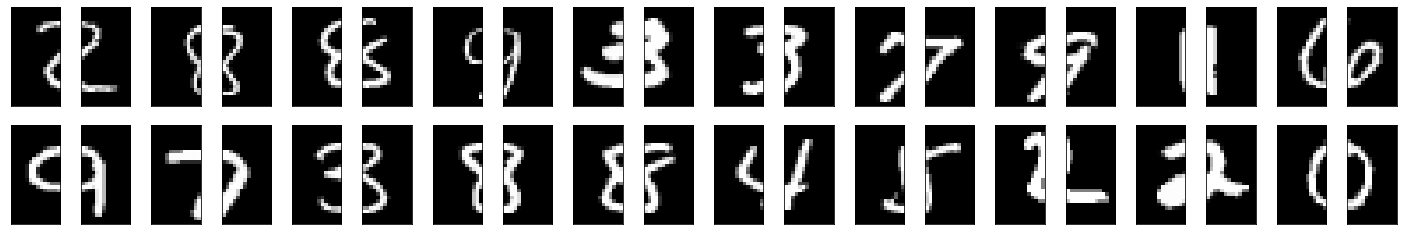

In [4]:
writer = SummaryWriter('runs')

transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307), (0.3081))
                            ]),

#Prepare the data. 60000 training instances and 10000 test instances.

train_data = datasets.MNIST(root='data', train=True,
                                download=True, 
                                transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                download=True, transform=transform)

# Divide each image into two parts. And translate the value of each pixel to the range [-1; 1].
# ========================================================= 
train_features = torch.FloatTensor(60000, 28, 14)
train_targets = torch.FloatTensor(60000, 28, 14)

train_features = (train_data.data[:, :, :14] - 127.5)/127.5
train_targets = (train_data.data[:, :, 14:] - 127.5)/127.5

test_features = torch.FloatTensor(10000, 28, 14)
test_targets = torch.FloatTensor(10000, 28, 14)

test_features = (test_data.data[:, :, :14] - 127.5)/127.5
test_targets = (test_data.data[:, :, 14:] - 127.5)/127.5
# ========================================================= 

# Converting data to a format that is convenient to use in PyTorch
# ========================================================= 
train_data_set = data_utils.TensorDataset(train_features, train_targets)
left_train_data_set = data_utils.TensorDataset(train_features, train_features)
right_train_data_set = data_utils.TensorDataset(train_targets, train_targets)
test_data_set = data_utils.TensorDataset(test_features, test_targets)

train_loader = data_utils.DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test_data_set, batch_size=batch_size, shuffle=True)

# Data for the autoencoder
# ---------------------------------------------------------
left_train_loader = data_utils.DataLoader(left_train_data_set, batch_size=batch_size, shuffle=True)
right_train_loader = data_utils.DataLoader(right_train_data_set, batch_size=batch_size, shuffle=True)
# ---------------------------------------------------------
# ========================================================= 


# Peeking into dataset
# ========================================================= 

    
dataiter = iter(test_loader)
left_images, right_images = dataiter.next()
left_images = left_images.numpy()
right_images = right_images.numpy()

fig = plt.figure(figsize=(25, 4))
for image in np.arange(40):
    ax = fig.add_subplot(2, 20, image+1, xticks=[], yticks=[])
    if (image%2 == 0):
        ax.imshow(np.squeeze(left_images[image//2]), cmap='gray')
    else:
        ax.imshow(np.squeeze(right_images[(image-1)//2]), cmap='gray')
# ========================================================= 

# PLS training

In [5]:
pls32 = PLSRegression(n_components=32, max_iter=2000)
pls32.fit(train_features.view(-1, 28*14), train_targets.view(-1, 28*14))

PLSRegression(copy=True, max_iter=2000, n_components=32, scale=True, tol=1e-06)

# DumbNet trainig

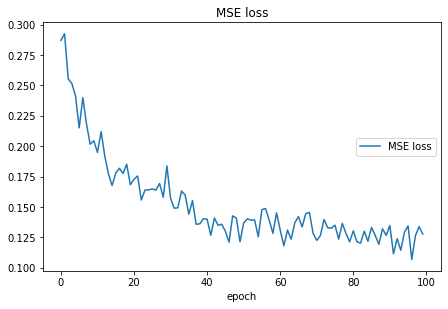

MSE loss
	MSE loss         	 (min:    0.107, max:    0.292, cur:    0.128)
Number of weight coefficients: 283968


In [6]:
dumb_net = DumbNet2(input_layer_size=28*14, criterion = nn.MSELoss())

optimizer = torch.optim.Adam(dumb_net.parameters(), lr=0.0001, weight_decay=1e-6)

dumb_net_solver = Solver(dumb_net, 100, batch_size, optimizer)

dumb_net_solver.fit(train_loader)

# Autoencoder trainig

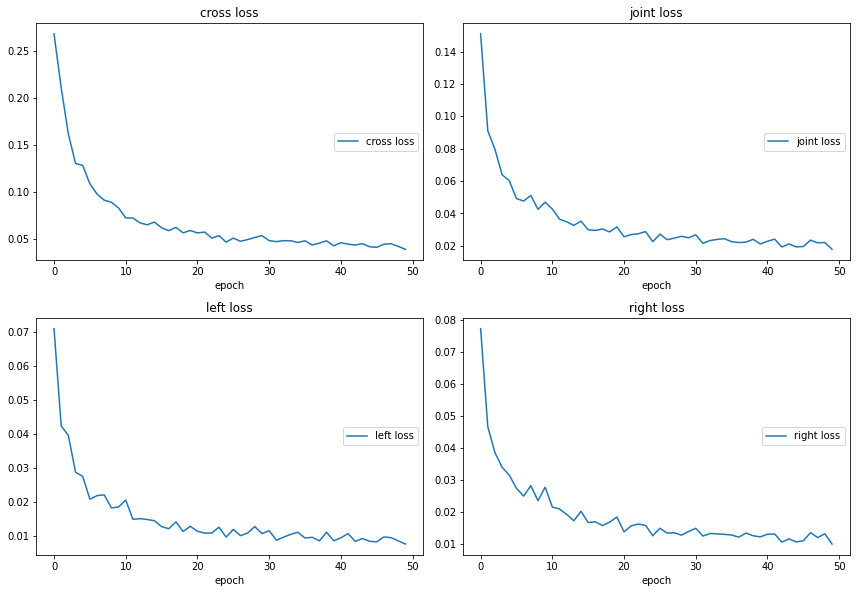

cross loss
	cross loss       	 (min:    0.012, max:    0.630, cur:    0.040)
joint loss
	joint loss       	 (min:    0.018, max:    0.173, cur:    0.018)
left loss
	left loss        	 (min:    0.008, max:    0.079, cur:    0.008)
right loss
	right loss       	 (min:    0.010, max:    0.090, cur:    0.010)


In [26]:
criterion = nn.MSELoss()

left_model = Autoencoder(28*14, criterion)
right_model = Autoencoder(28*14, criterion)

print(right_model)

optimizer = torch.optim.Adam(
    list(left_model.parameters())+list(right_model.parameters()), lr=0.001, weight_decay=1e-6)

from livelossplot import PlotLosses
liveloss = PlotLosses()
logs = {}

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.float())
        target = Variable(target.float())
        data = data.view(-1, 28*14)
        target = target.view(-1, 28*14)
        optimizer.zero_grad()

        left_net_out = left_model(data)
        right_net_out = right_model(target)

        left_model.encoder(data)
        right_model.encoder(target)
        left_loss = criterion(left_net_out, data)
        right_loss = criterion(right_net_out, target)
        cross_loss = criterion(left_model.encoder(data), right_model.encoder(target))
        joint_losses = left_loss + right_loss + 1e-2*cross_loss
        joint_losses.backward()
        optimizer.step()   
     
    epoch_joint_losses = joint_losses.detach()
    epoch_left_loss = left_loss.detach()
    epoch_right_loss = right_loss.detach()
    epoch_cross_loss = cross_loss.detach()
    logs['joint '+'loss'] = epoch_joint_losses.item()
    logs['left '+'loss'] = epoch_left_loss.item()
    logs['right '+'loss'] = epoch_right_loss.item()
    logs['cross '+'loss'] = epoch_cross_loss.item()
    liveloss.update(logs)
    liveloss.send()



## autoencoder check

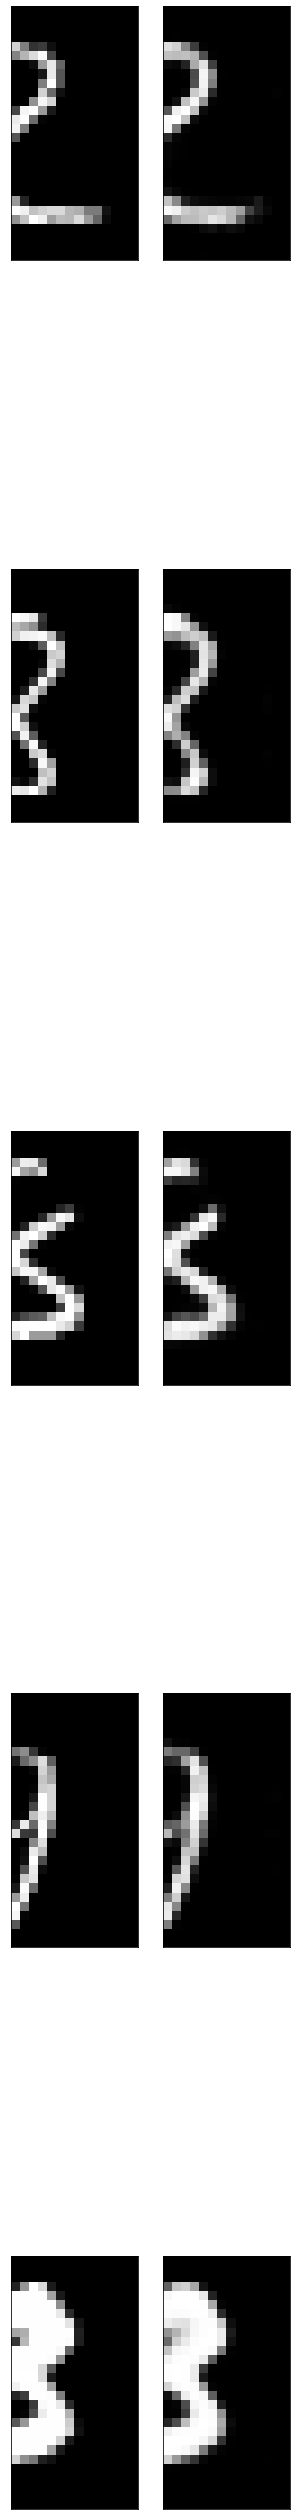

In [8]:
autoencoder = right_model(torch.from_numpy(right_images).view(-1, 28*14))
autoencoder = autoencoder.detach().view(-1, 28,14)
autoencoder = autoencoder.cpu().numpy()

fig = plt.figure(figsize=(5, 50))
j=0
for i in np.arange(5):
    ax1 = fig.add_subplot(5, 2, j+1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(right_images[i]), cmap='gray')
    ax2 = fig.add_subplot(5, 2, j+2, xticks=[], yticks=[])
    ax2.imshow(np.squeeze(autoencoder[i]), cmap='gray')
    j += 2

# Training model after applying autoencoder 

## EncNet

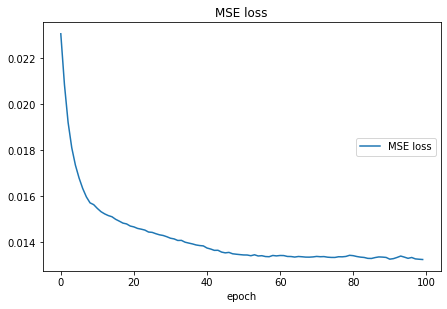

MSE loss
	MSE loss         	 (min:    0.005, max:    0.292, cur:    0.013)
Number of weight coefficients: 46400


In [27]:
# Data preparation

autoencoder_train_data_set = data_utils.TensorDataset(left_model.encoder(train_features.view(-1, 28*14)), right_model.encoder(train_targets.view(-1, 28*14)))
autoencoder_test_data_set = data_utils.TensorDataset(left_model.encoder(test_features.view(-1, 28*14)), right_model.encoder(test_targets.view(-1, 28*14)))

autoencoder_train_loader = data_utils.DataLoader(autoencoder_train_data_set, batch_size=batch_size, shuffle=False)
autoencoder_test_loader = data_utils.DataLoader(autoencoder_test_data_set, batch_size=batch_size, shuffle=False)

# create a loss function
criterion = nn.MSELoss()
enc_net = EncNet(32, criterion)

print(enc_net)

optimizer = torch.optim.Adam(
    enc_net.parameters(), lr=0.0007, weight_decay=1e-6)

enc_net_solver = Solver(enc_net, 100, batch_size, optimizer)
enc_net_solver.fit(autoencoder_train_loader)

## LinearNet

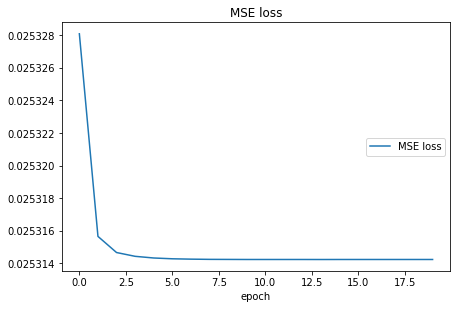

MSE loss
	MSE loss         	 (min:    0.005, max:    0.292, cur:    0.025)
Number of weight coefficients: 2048


In [28]:
# Data preparation

autoencoder_train_data_set = data_utils.TensorDataset(left_model.encoder(train_features.view(-1, 28*14)), right_model.encoder(train_targets.view(-1, 28*14)))
autoencoder_test_data_set = data_utils.TensorDataset(left_model.encoder(test_features.view(-1, 28*14)), right_model.encoder(test_targets.view(-1, 28*14)))

autoencoder_train_loader = data_utils.DataLoader(autoencoder_train_data_set, batch_size=batch_size, shuffle=False)
autoencoder_test_loader = data_utils.DataLoader(autoencoder_test_data_set, batch_size=batch_size, shuffle=False)

# create a loss function
criterion = nn.MSELoss()
linear_net = LinearNet(32, criterion)

optimizer = torch.optim.Adam(
    linear_net.parameters(), lr=0.01, weight_decay=1e-6)

linear_net_solver = Solver(linear_net, 20, batch_size, optimizer)
linear_net_solver.fit(autoencoder_train_loader)

# Testing

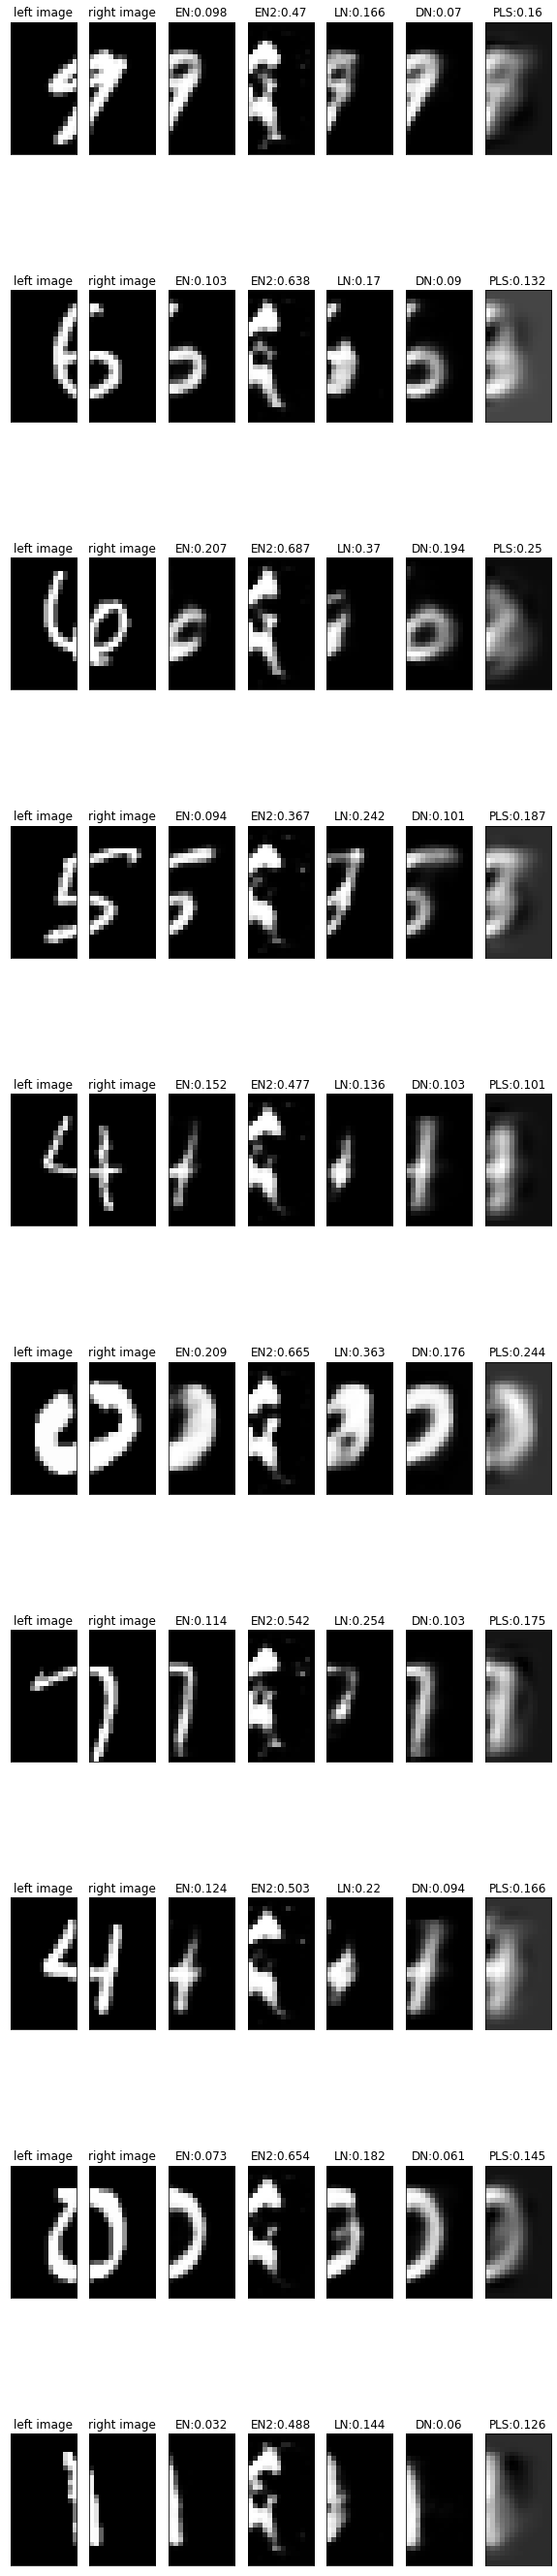

In [34]:
j = 1
criterion = nn.MSELoss()
fig = plt.figure(figsize = (10,50)) 
for i in range(20, 30):
    encoded = left_model.encoder(test_features[i].view(28*14)) 

    EncNet_pred_encoded = enc_net(encoded)
    EncNet_pred = right_model.decoder(EncNet_pred_encoded).detach().view(28,14).cpu().numpy()

    EncNet2_pred_encoded = enc_net2(encoded)
    EncNet2_pred = right_model.decoder(EncNet2_pred_encoded).detach().view(28,14).cpu().numpy()

    LinearNet_pred_encoded = linear_net(encoded)
    LinearNet_pred = right_model.decoder(LinearNet_pred_encoded).detach().view(28,14).cpu().numpy()

    DumbNet_pred = dumb_net(test_features[i].view(28*14)).detach().view(28,14).cpu().numpy()

    PLS_pred = np.reshape(pls32.predict(test_features[i].view(-1, 28*14)), (28, 14))

    ax1 = fig.add_subplot(10, 7, j, xticks=[], yticks=[])
    ax1.set_title("left image")
    ax1.imshow(test_features[i], cmap='gray')

    ax2 = fig.add_subplot(10, 7, j+1, xticks=[], yticks=[])
    ax2.set_title("right image")
    ax2.imshow(test_targets[i], cmap='gray')

    ax3 = fig.add_subplot(10, 7, j+2, xticks=[], yticks=[])
    label = round(float(criterion(torch.from_numpy(EncNet_pred).view(28*14), test_targets[i].view(28*14))), 3)
    ax3.set_title("EN:" + str(label))
    ax3.imshow(EncNet_pred, cmap='gray')
    
    ax4 = fig.add_subplot(10, 7, j+3, xticks=[], yticks=[])
    label = round(float(criterion(torch.from_numpy(EncNet2_pred).view(28*14), test_targets[i].view(28*14))), 3)
    ax4.set_title("EN2:" + str(label))
    ax4.imshow(EncNet2_pred, cmap='gray')

    ax5 = fig.add_subplot(10, 7, j+4, xticks=[], yticks=[])
    label = round(float(criterion(torch.from_numpy(LinearNet_pred).view(28*14),test_targets[i].view(28*14))), 3)
    ax5.set_title("LN:" + str(label))
    ax5.imshow(LinearNet_pred, cmap='gray')

    ax6 = fig.add_subplot(10, 7, j+5, xticks=[], yticks=[])
    label = round(float(criterion(torch.from_numpy(DumbNet_pred).view(28*14), test_targets[i].view(28*14))), 3)
    ax6.set_title("DN:" + str(label))
    ax6.imshow(DumbNet_pred, cmap='gray')

    ax7 = fig.add_subplot(10, 7, j+6, xticks=[], yticks=[])
    label = round(float(criterion(torch.from_numpy(PLS_pred).view(28*14), test_targets[i].view(28*14))), 3)
    ax7.set_title("PLS:" + str(label))
    ax7.imshow(PLS_pred, cmap='gray')
    
    j = j + 7


In [0]:
loss1 = []
loss2 = []
loss3 = []
loss4 = []
loss5 = []
losses = [loss1, loss2, loss3, loss4, loss5]
criterion = nn.MSELoss()
for i in range(len(test_features)):

    encoded = left_model.encoder(test_features[i].view(28*14)) 

    EncNet_pred_encoded = enc_net(encoded)
    EncNet_pred = right_model.decoder(EncNet_pred_encoded).detach().cpu()

    EncNet2_pred_encoded = enc_net2(encoded)
    EncNet2_pred = right_model.decoder(EncNet2_pred_encoded).detach().cpu()

    LinearNet_pred_encoded = linear_net(encoded)
    LinearNet_pred = right_model.decoder(LinearNet_pred_encoded).detach().cpu()

    DumbNet_pred = dumb_net(test_features[i].view(28*14)).detach().cpu()

    PLS_pred = torch.from_numpy(pls32.predict(test_features[i].view(-1, 28*14))).view(28*14)

    losses[0].append(round(float(criterion(EncNet_pred, test_targets[i].view(28*14))), 5))
    losses[1].append(round(float(criterion(EncNet2_pred, test_targets[i].view(28*14))), 5))
    losses[2].append(round(float(criterion(LinearNet_pred, test_targets[i].view(28*14))), 5))
    losses[3].append(round(float(criterion(DumbNet_pred, test_targets[i].view(28*14))), 5))
    losses[4].append(round(float(criterion(PLS_pred, test_targets[i].view(28*14))), 5))

In [0]:
import statistics
losses[0] = statistics.mean(losses[0])
losses[1] = statistics.mean(losses[1])
losses[2] = statistics.mean(losses[2])
losses[3] = statistics.mean(losses[3])
losses[4] = statistics.mean(losses[4])

In [32]:
print("EncNet loss:    ", losses[0], "\nEncNet2 loss:   ", losses[1], " \nLinearNet loss: ", losses[2], " \nDumbNet loss:   ", losses[3], "\nPLS loss:       ", losses[4])

EncNet loss:     0.146661715 
EncNet2 loss:    0.526790236  
LinearNet loss:  0.234791718  
DumbNet loss:    0.12844069 
PLS loss:        0.188374132


# Результаты


Сложность моделей, измеряемая в кол-ве весов:

*   **EncNet loss**: 283968
*   **LinearNet loss**: 239616
*   **DumbNet loss**: 283968


-----------------------------------------------------
-----------------------------------------------------


Без совместной функции потерь:


*   **EncNet loss**:   0.14847718 
*   **LinearNet loss**: 0.236270102
*   **DumbNet loss**: 0.12844069 
*   **PLS loss**: 0.188374132


-----------------------------------------------------
Коэффициент перед совместной функцией потерь $\alpha = 10^{-2}$

*   **EncNet loss**: 0.146661715 
*   **LinearNet loss**: 0.146661715
*   **DumbNet loss**: 0.12844069 
*   **PLS loss**: 0.188374132

-----------------------------------------------------
Коэффициент перед совместной функцией потерь $\alpha = 10^{-1}$

*   **EncNet loss**: 0.152047665
*   **LinearNet loss**: 0.242692969
*   **DumbNet loss**: 0.12844069
*   **PLS loss**: 0.188374132




-----------------------------------------------------

In [6]:
import torch

import torch.nn as nn

In [2]:
input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)

In [4]:
input

tensor([[[[1., 2.],
          [3., 4.]]]])

In [11]:
 m = nn.Upsample(scale_factor=2)

In [12]:
m(input)

tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]])